In [3]:
import xarray as xr
# import glob
# import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
# from shapely.geometry import Point
import numpy as np

# from google.cloud import storage
# import gcsfs
# import zarr

import xskillscore as xs
import pandas as pd

# import os

import re
import skill_metrics as sm

import matplotlib.lines as mlines
import seaborn as sns

In [18]:
results = xr.open_dataset('results_2022_ens.nc')
print(results)


<xarray.Dataset> Size: 164MB
Dimensions:                                    (prediction_timedelta: 16,
                                                time: 354, station: 47)
Coordinates:
  * prediction_timedelta                       (prediction_timedelta) timedelta64[ns] 128B ...
  * time                                       (time) datetime64[ns] 3kB 2022...
  * station                                    (station) <U5 940B '06201' ......
    lat                                        (station) float64 376B ...
    lon                                        (station) float64 376B ...
    valid_time                                 (time, prediction_timedelta) datetime64[ns] 45kB ...
Data variables: (12/105)
    2m_temperature_hres                        (time, prediction_timedelta, station) float32 1MB ...
    mean_sea_level_pressure_hres               (time, prediction_timedelta, station) float32 1MB ...
    10m_v_component_of_wind_hres               (time, prediction_timedelta, stat

### Statistics functions

In [24]:
def calculate_statistic(results, statistic_method, model_suffix='hres', variable=None, date_ranges=None, by_station=False):
    """
    Calculate a statistical method (e.g., RMSE, MAE, Pearson R, Bias) between forecast and observation data.

    Parameters:
        results (xarray.Dataset): The dataset containing the forecast and observation variables.
        statistic_method (str): The statistical method to use for the calculation.
        model_suffix (str): The suffix used in the forecast variables to distinguish them (default is '_hres').
        variable (str): Specific variable to analyze. If None, analyze all variables.
        date_ranges (list of tuples): List of date ranges to filter the data. Each tuple should be (start_date, end_date).
        by_station (bool): If True, calculate the statistic separately for each station. Default is False.

    Returns:
        xarray.Dataset: A dataset containing the calculated statistical results.
    """
    # Define supported methods, including the new 'bias' method
    supported_methods = {
        'rmse': lambda forecast, obs, dim: xs.rmse(forecast, obs, dim=dim, skipna=True),
        'mae': lambda forecast, obs, dim: xs.mae(forecast, obs, dim=dim, skipna=True),
        'mse': lambda forecast, obs, dim: xs.mse(forecast, obs, dim=dim, skipna=True),
        'pearson_r': lambda forecast, obs, dim: xs.pearson_r(forecast, obs, dim=dim, skipna=True),
        'spearman_r': lambda forecast, obs, dim: xs.spearman_r(forecast, obs, dim=dim, skipna=True),
        'bias': lambda forecast, obs, dim: (forecast - obs).mean(dim=dim, skipna=True),  # Bias calculation
        'mean_absolute_percentage_error': lambda forecast, obs, dim: xs.mape(forecast, obs, dim=dim, skipna=True),
        'brier_score': lambda forecast, obs, dim: xs.brier_score(forecast, obs, dim=dim, skipna=True),
        'threshold_brier_score': lambda forecast, obs, dim: xs.threshold_brier_score(forecast, obs, dim=dim, skipna=True),
        'crps_gaussian': lambda forecast, obs, dim: xs.crps_gaussian(forecast, obs, dim=dim, skipna=True),
        'crps_quadrature': lambda forecast, obs, dim: xs.crps_quadrature(forecast, obs, dim=dim, skipna=True),
        'crps_ensemble': lambda forecast, obs, dim: xs.crps_ensemble(forecast, obs, dim=dim, skipna=True),
        'rank_histogram': lambda forecast, obs, dim: xs.rank_histogram(forecast, obs, dim=dim, skipna=True),
        'roc': lambda forecast, obs, dim: xs.roc(forecast, obs, dim=dim, skipna=True),
        'reliability': lambda forecast, obs, dim: xs.reliability(forecast, obs, dim=dim, skipna=True),
        'discrimination': lambda forecast, obs, dim: xs.discrimination(forecast, obs, dim=dim, skipna=True),
        'rps': lambda forecast, obs, dim: xs.rps(forecast, obs, dim=dim, skipna=True)
    }

    # Check if the method is supported
    if statistic_method not in supported_methods:
        raise ValueError(f"Statistic method '{statistic_method}' is not supported. Choose from {list(supported_methods.keys())}.")

    # If date ranges are provided, filter the data accordingly
    if date_ranges:
        datasets = [results.sel(time=slice(start_date, end_date)) for start_date, end_date in date_ranges]
        results = xr.concat(datasets, dim='time')

    # Define the variables to compare (forecast vs observation)
    variables = {
        f'2m_temperature_{model_suffix}': '2m_temperature_synop',
        f'mean_sea_level_pressure_{model_suffix}': 'mean_sea_level_pressure_synop',
        f'10m_wind_speed_{model_suffix}': '10m_wind_speed_synop',
        f'10m_wind_direction_{model_suffix}': '10m_wind_direction_synop',
        f'10m_v_component_of_wind_{model_suffix}': '10m_v_component_of_wind_synop',
        f'10m_u_component_of_wind_{model_suffix}': '10m_u_component_of_wind_synop',
        f'total_precipitation_6hr_{model_suffix}': 'total_precipitation_6hr_synop'


    }
    

    if variable:
        variables = {f'{variable}_{model_suffix}': f'{variable}_synop'}

    # Determine the dimensions to calculate over
    dims = ['time']
    if not by_station:
        dims.append('station')

    # Apply the selected statistic method to each variable
    results = xr.Dataset({
        forecast_var: supported_methods[statistic_method](results[forecast_var], results[obs_var], dim=dims)
        for forecast_var, obs_var in variables.items()
    })

    return results

def calculate_all_statistics(results_chunked, metrics, models, by_station=False):
    """
    Calculates statistical metrics for different models and variables.

    Parameters:
    - results_chunked: The dataset or collection of results to be analyzed. This is typically a large
      dataset split into chunks.
    - metrics: A list of statistical metrics to be calculated (e.g., ['rmse', 'mae']).
    - models: A list of models or variables for which the metrics are calculated (e.g., ['hres', 'gc', 'analysis', 'meso']).

    Returns:
    - statistics: A dictionary where each key is a combination of a metric and a model
      (e.g., 'rmse_hres', 'mae_gc') and the value is the computed statistic for that combination.
    """
    statistics = {}
    for metric in metrics:
        for model in models:
            key = f"{metric}_{model}"
            statistics[key] = calculate_statistic(
                results_chunked, 
                metric, 
                model, 
                by_station=by_station
            )
    return statistics

### Plotting functions

In [6]:
def plot_statistic_results(statistics, error_metric, save_path=None):
    """
    Plots the statistical results for predefined variables against forecast lead time for one or multiple datasets.

    Parameters:
        error_metric (str): The error metric to plot (e.g., 'rmse', 'mse', 'mae').
        save_path (str, optional): The file path to save the plot. If None, the plot will be displayed.

    Returns:
        None
    """
    # Ensure that the error_metric is matched as a prefix in the keys
    datasets = [statistics[key] for key in statistics.keys() if key.startswith(error_metric + "_")]

    if len(datasets) == 0:
        raise ValueError(f"No dataset matches the error metric: {error_metric}")
    
    # Check if each dataset is an xarray Dataset
    for i, ds in enumerate(datasets):
        if not hasattr(ds, 'data_vars'):
            raise TypeError(f"Dataset {i+1} is not an xarray.Dataset. Ensure you pass the dataset object, not its name as a string.")
    
    # Define variable names and their corresponding units
    variables = {
        '2m_temperature': '°C',
        'mean_sea_level_pressure': 'hPa',
        '10m_wind_speed': 'm/s',
        '10m_wind_direction': '°',
        'total_precipitation_6hr': 'mm'
    }
    
    # Convert lead times to numeric values (hours) for plotting
    lead_times_numeric_list = [ds['prediction_timedelta'].dt.total_seconds() / 3600 for ds in datasets]
    
    # Ensure lead times match between datasets if there are multiple
    if len(datasets) > 1:
        for i in range(1, len(lead_times_numeric_list)):
            if not lead_times_numeric_list[i].equals(lead_times_numeric_list[0]):
                raise ValueError("Lead times in the datasets do not match.")
    
    # Extract base variable names and model suffixes
    def extract_base_variable_name(var_name):
        match = re.match(r'^(.*)_(.+)$', var_name)
        if match:
            return match.groups()
        else:
            return var_name, None
    
    variables_dict_list = []
    for ds in datasets:
        variables_dict = {extract_base_variable_name(var)[0]: var for var in ds.data_vars}
        variables_dict_list.append(variables_dict)
    
    # Initialize the figure and subplots
    fig, axs = plt.subplots(len(variables), 1, figsize=(10, 3 * len(variables)))

    if len(variables) == 1:
        axs = [axs]

    line_styles = [':', '--', '-.', '-', ':']
    line_colors = [
        'green','cyan', 'blue', 'orange', 'red', 'purple', 'magenta', 'brown', 
        'black', 'darkblue', 'darkgreen', 'darkred', 'teal', 'darkorange', 'navy'
    ]

    
    # Track the overall minimum value across all datasets for setting the y-limit
    global_min = float('inf')

    # Loop through variables to plot
    for i, (base_var, unit) in enumerate(variables.items()):
        for j, (ds, variables_dict) in enumerate(zip(datasets, variables_dict_list)):
            if base_var in variables_dict:
                var = variables_dict[base_var]
                _, model_suffix = extract_base_variable_name(var)
                label = model_suffix if len(datasets) > 1 else 'Observation'
                axs[i].plot(lead_times_numeric_list[j], ds[var], marker='o', markersize=3, linestyle=line_styles[j % len(line_styles)], color=line_colors[j % len(line_colors)],
                            alpha=0.75, linewidth=1, label=label)

                # Update the global minimum
                global_min = min(global_min, ds[var].min())
        
        axs[i].set_title(f'{base_var.replace("_", " ").title()} vs Observation', fontsize=14)
        axs[i].set_xlabel('Lead Time (hours)', fontsize=12)
        axs[i].set_ylabel(f'{error_metric.upper()} ({unit})', fontsize=12)
        axs[i].grid(True, linestyle='--', linewidth=0.5)
        axs[i].set_xticks(range(0, int(max(lead_times_numeric_list[0])) + 1, 6))

        # Add a legend to the right of each subplot
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, frameon=False)


    # # Uncomment the following block to set y-axis limits based on the metric
    
    # # Set y-axis limit after processing all datasets
    #     # Set y-axis limits based on metric
    #     if error_metric == 'pearson_r':
    #         axs[i].set_ylim(top=1.0)  # Top limit is set to 1.0
    #     elif global_min >= 0:
    #                 axs[i].set_ylim(bottom=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
        plt.close()
    else:
        plt.show()

def plot_statistics_for_variable(statistics, variable, metrics=['rmse', 'mae', 'mse', 'bias'], save_path=None):
    """
    Plots multiple statistical metrics (e.g., rmse, mae, mse, bias) for a single variable
    across different models and metrics, with units displayed on the vertical axis.

    Parameters:
        statistics (dict): A dictionary containing datasets with metric-model combinations as keys.
        variable (str): The variable to plot (e.g., '2m_temperature').
        save_path (str, optional): The file path to save the plot. If None, the plot will be displayed.

    Returns:
        None
    """
    
    variable_units = {
        '2m_temperature': '°C',
        'mean_sea_level_pressure': 'hPa',
        '10m_wind_speed': 'm/s',
        '10m_v_component_of_wind': 'm/s',
        '10m_u_component_of_wind': 'm/s',
        'total_precipitation_6hr': 'mm'
    }
    
    unit = variable_units.get(variable, '')  # Get unit for the variable
    
    metric_model_combinations = [key for key in statistics.keys() if any(metric in key for metric in metrics)]
    
    fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 3 * len(metrics)))

    if len(metrics) == 1:
        axs = [axs]

    line_styles = [':', '--', '-.', '-', ':']
    line_colors = [
        'green','cyan', 'blue', 'orange', 'red', 'purple',  'magenta', 'brown', 
        'black', 'darkblue', 'darkgreen', 'darkred', 'teal', 'darkorange', 'navy'
    ]


    # Track the overall minimum and maximum values across all variables for setting the y-limit
    global_min = float('inf')
    global_max = float('-inf')

    for i, metric in enumerate(metrics):
        for j, key in enumerate(metric_model_combinations):
            if key.startswith(metric):
                ds = statistics[key]
                model_suffix = key.split("_")[1]
                variable_key = f'{variable}_{model_suffix}'

                if variable_key in ds.data_vars:
                    lead_times = ds['prediction_timedelta'].dt.total_seconds() / 3600
                    var_data = ds[variable_key]
                    axs[i].plot(lead_times, var_data, marker='o', markersize=3, linestyle=line_styles[j % len(line_styles)], color=line_colors[j % len(line_colors)], 
                                alpha=0.75, linewidth=1, label=model_suffix)

                    # Update the global minimum and maximum
                    global_min = min(global_min, var_data.min())
                    global_max = max(global_max, var_data.max())
        
        axs[i].set_title(f'{metric.upper()} for {variable.replace("_", " ").title()}', fontsize=14)
        axs[i].set_xlabel('Lead Time (hours)', fontsize=12)
        axs[i].set_ylabel(f'{metric.upper()} ({unit})', fontsize=12)
        axs[i].grid(True, linestyle='--', linewidth=0.5)
        axs[i].set_xticks(range(0, int(max(lead_times)) + 1, 6))

        # Add a legend to the right of each subplot
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, frameon=False)
        
        # Set y-axis limits based on metric
        if metric == 'pearson_r':
            axs[i].set_ylim(top=1.0)  # Top limit is set to 1.0
            print('doing something with pearson_r')
        else:
            if global_min >= 0:
                axs[i].set_ylim(bottom=0)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
        plt.close()
    else:
        plt.show()


### Plot generation

In [25]:
metrics = ['rmse','mae', 'bias']
models = ['analysis','ERA5', 'meso', 'hres', 'gc', 'pangu', 'ens']
variables = ['2m_temperature', 'mean_sea_level_pressure', '10m_wind_speed', '10m_wind_direction' 'total_precipitation_6hr']

statistics = calculate_all_statistics(results, metrics, models)

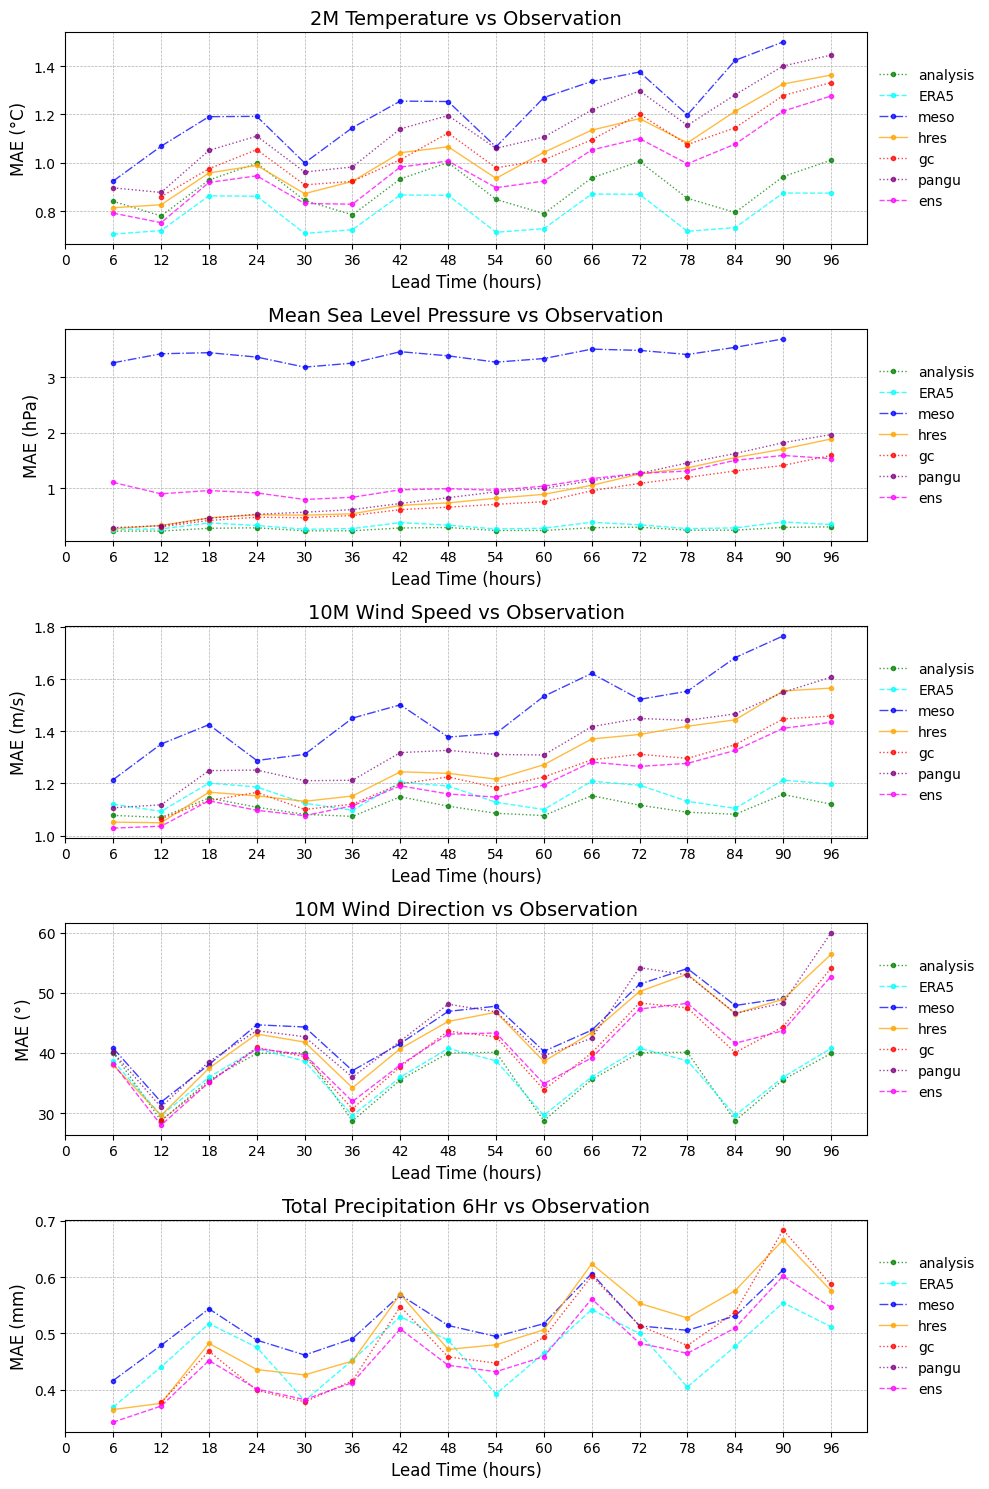

In [26]:
plot_statistic_results(statistics, 'mae')

### Saving plots to file

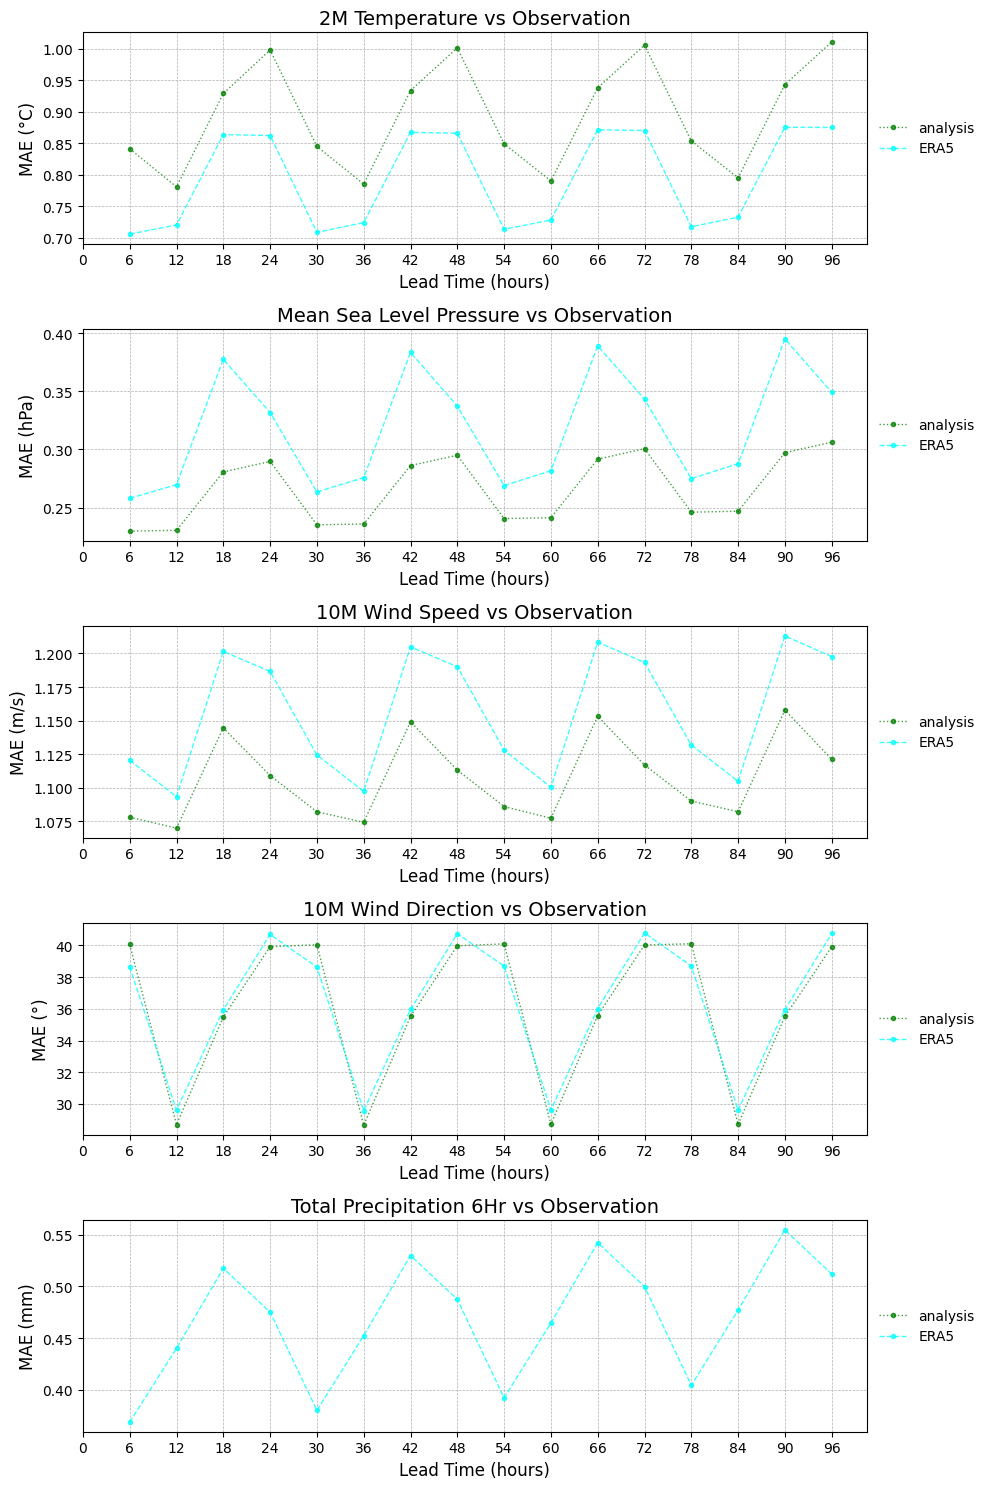

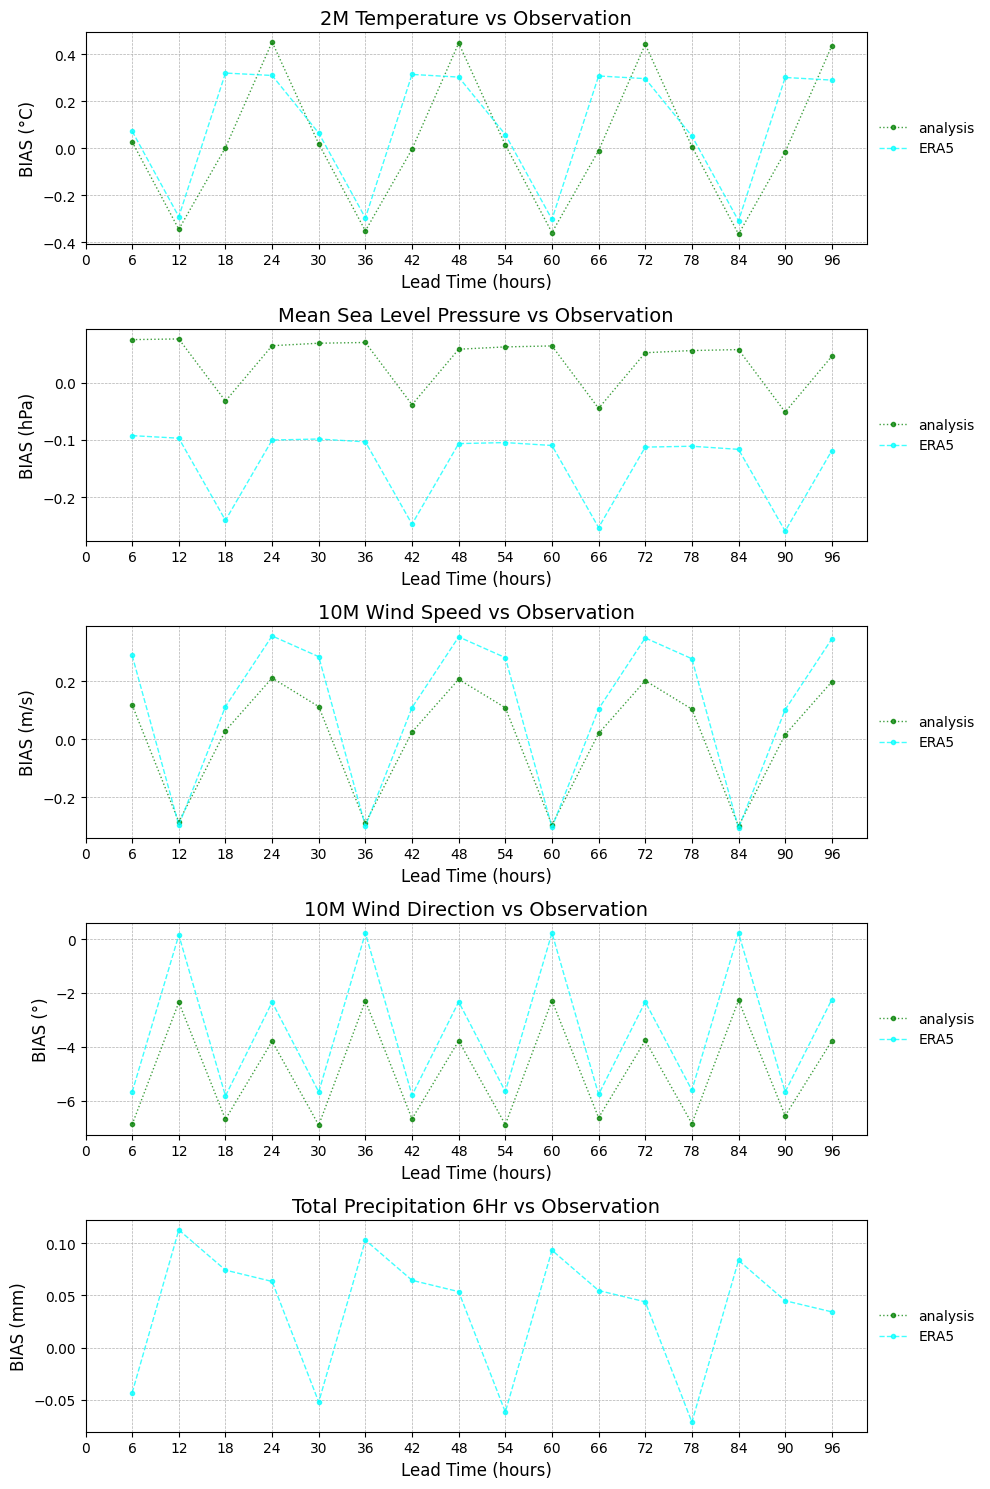

In [26]:
metrics = ['mae', 'bias']
models = ['analysis','ERA5']
variables = ['10m_wind_speed', '10m_wind_direction']

statistics = calculate_all_statistics(results, metrics, models)

# for variable in variables:
#     _metrics = ['rmse', 'mae', 'bias']
#     save_path=f'lead_time_plots_ens/by_variable/lead_time_{variable}.png'
#     save_path = None
#     plot_statistics_for_variable(statistics, variable, metrics=_metrics, save_path=save_path)

for metric in metrics:
    save_path=f'lead_time_plots_ens/by_metric/lead_time_{metric}.png'
    save_path = None
    plot_statistic_results(statistics, metric, save_path=save_path)